# Group Final project

### *Group24: Haibin Yu, Eric Zhang, Muhan Yang, Shuhao Zhang*

## Title

An observation into testing the existence of the gender wage gap in Canada in 2016.

## Introduction

The gender wage gap refers to the difference between wages earned by men and women, which can be measured using the difference in either mean or median of the wages (*The Gender Wage Gap: It’s More Than You Think*, n.d.).

**Question:** Is there a significant difference in wages between men and women in Canada in 2016 in the data?

The data set is a DTA file of the 2016 Canadian census downloaded from the website of Statistics Canada (see url: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/index-eng.cfm), containing 16 columns of variables and 391,938 rows. This data describes the enumeration of Canadian residents in 2016. The data is filtered to contain only the variables of interest: "sex" and “wages”. The sex variable in this dataset is a categorical variable represented numerically with 1 and 2 representing female and male, respectively. The variable “wages” is a quantitative variable represented by whole numbers above 0.


The response variable is the wage of the individual observed represented by “wages”.
The location parameter to be used to describe the center of the wage distribution is the median as it will not be affected by outliers in the wage data.
The scale parameter to be used is the standard deviation of wages which can be used to describe the variability of wages between males and females.

The null hypothesis for this test is that there is no difference in wages between males and females in the dataset. The alternative hypothesis would be the existence of a difference in wages between the males and females (Pelletier, 2019). A t-test can be used to compare the median wages of males and females. Based on the p-value of the test it can be determined whether or not the null hypothesis should be rejected and determine the existence of a significant differences in wages between measles and females in the dataset.



## Methods and Results

In [62]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(haven)

In [63]:
dropbox_url <- "https://dl.dropboxusercontent.com/s/lft2crtr48tu2p4/census2016.dta?dl=0"
read_dta(dropbox_url) ->data
head(data)


ppsort,agegrp,ageimm,cip2011,fol,hdgree,immstat,kol,lfact,locstud,mrkinc,pkids,pr,sex,vismin,wages
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
453141,11,99,8,1,4,1,1,1,6,97000,1,35,2,13,95000
732612,12,99,6,1,9,1,3,1,6,41000,1,35,1,13,19000
143665,15,99,5,2,6,1,3,1,2,30000,0,11,1,13,29000
52611,14,99,11,2,3,1,2,1,5,54000,0,24,2,13,52000
36927,8,99,13,1,2,1,1,1,99,27000,1,35,2,13,27000
268123,11,99,13,1,2,1,1,1,99,40000,1,35,2,13,57000


In [64]:
# filter data with columns needed - sex and wages
data <- data %>%
    select(sex, wages) %>%
# convert sex from numeric form into categorical form for plotting later
    mutate(sex = factor(sex, labels = c("female", "male"))) %>% 
    filter(!is.na(wages), wages != "1")
head(data)

sex,wages
<fct>,<dbl>
male,95000
female,19000
female,29000
male,52000
male,27000
male,57000


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 8105 rows containing non-finite values (stat_boxplot).”


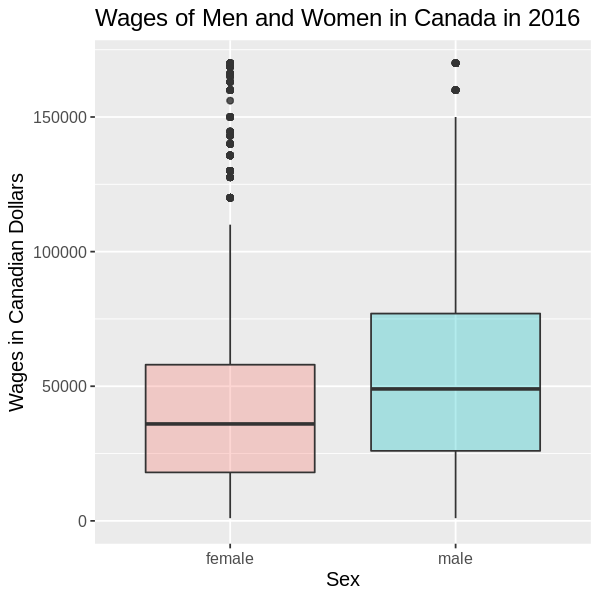

In [65]:
# using boxplot to plot the relevant raw data, as it helps to get a glimpse of the wage range of each sex and compare sample statistics
  # like median and interquartile range in two groups

data <- 
    data %>% 
    filter(sex %in% c("female", "male"))

sex_wages_boxplots <- data %>% 
    ggplot() +
    geom_boxplot(aes(sex, wages, fill = sex),
                alpha = 0.3) + # change transparency of colours
    ylim(0,170000) + # find a suitable limit for wages (y-axis) after looking the graph with outliers beforehand
    theme(text = element_text(size = 12)) +
    ggtitle("Wages of Men and Women in Canada in 2016") + 
    xlab("Sex") + 
    ylab("Wages in Canadian Dollars") +
    guides(fill = FALSE)

options(repr.plot.width = 5, repr.plot.height = 5)
sex_wages_boxplots

In [66]:
# filter out all NA values for wages, compute estimates of the parameter in the following table of summary 
# including median, mean and standard deviation of wages, and the total number of people for both sexes respectively

data_summary <- data %>%
    filter(!is.na(wages)) %>%
    group_by(sex) %>%
    summarize(med = median(wages),
              mean = mean(wages),
             sd = sd(wages),
             n = n())

data_summary

sex,med,mean,sd,n
<fct>,<dbl>,<dbl>,<dbl>,<int>
female,36000,43954.87,38693.30,164476
male,51000,65095.04,79952.77,176072


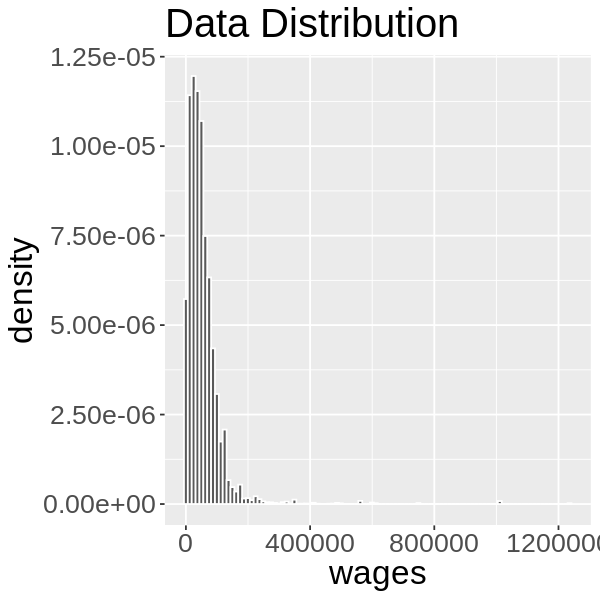

In [67]:
 ggplot(data, aes(x = wages)) + 
    geom_histogram(bins = 100, aes(y = ..density..), color = 'white') +
    ggtitle("Data Distribution") +
    theme(text = element_text(size = 20))

In [68]:
# calculate the mean and standard deviation for each group (males and females)
male_data <- data %>% filter(sex == "male")
female_data <- data %>% filter(sex == "female")

male_mean <- mean(male_data$wages)
female_mean <- mean(female_data$wages)

male_sd <- sd(male_data$wages)
female_sd <- sd(female_data$wages)

male_n <- nrow(male_data)
female_n <- nrow(female_data)

# we can calculate the mean difference and the standard error
mean_diff <- male_mean - female_mean


standard_error <- sqrt((male_n^2/nrow(data))+(female_n^2/nrow(data)))

# Now we can calculate the confidence interval for the mean difference
alpha <- 0.05  # 95% confidence interval
t_value <- qt(1 - alpha/2, df = male_n + female_n - 2)

lower_bound <- mean_diff - t_value * standard_error
upper_bound <- mean_diff + t_value * standard_error

confidence_interval <- c(lower_bound, upper_bound)
confidence_interval



[1] 20330.93 21949.40

## Asymptotics

In [69]:
set.seed(2023)
sample_mean <- 
    data %>% 
    rep_sample_n(reps = 1000, size = 1000, replace = FALSE) %>% 
    group_by(replicate) %>% 
    summarize(bootstrap_mean = mean(wages))


In [70]:
wage_ci1 <- sample_mean %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

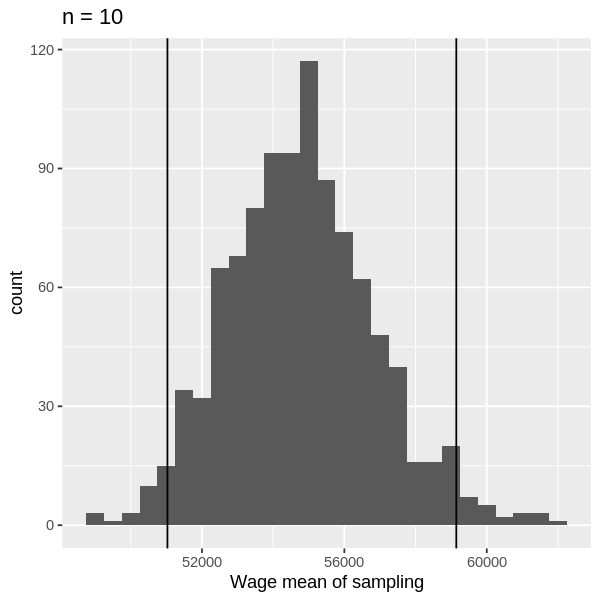

In [71]:
sample_mean %>% 
ggplot(aes(x = bootstrap_mean)) +
        geom_histogram(binwidth = 500) +
        xlab("Wage mean of sampling") +
         geom_vline(xintercept = wage_ci1[[1]]) +
        geom_vline(xintercept = wage_ci1[[2]]) +
        ggtitle("n = 10") 

In [72]:
t_test_result <- t.test(wages ~ sex, data = data)

# Print the t-test result
t_test_table <- tidy(t_test_result)
t_test_table



estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-21140.17,43954.87,65095.04,-99.2064,0,258062.9,-21557.82,-20722.51,Welch Two Sample t-test,two.sided


### boostraping

In [73]:
# bootstrap with 1000 replicates
set.seed(2023)
sample_1 <- 
    data %>% 
    rep_sample_n(reps = 10000, size = 10, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(bootstrap_mean = mean(wages))

# compute 95% confidence interval
wage_ci1 <- sample_1 %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

In [74]:
wage_ci1

lower_ci,upper_ci
<dbl>,<dbl>
28900,107347.5


In [75]:
set.seed(2023)
sample_2 <- 
    data %>% 
    rep_sample_n(reps = 10000, size = 10, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(bootstrap_med = median(wages))

# compute 95% confidence interval
wage_ci2 <- sample_2 %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

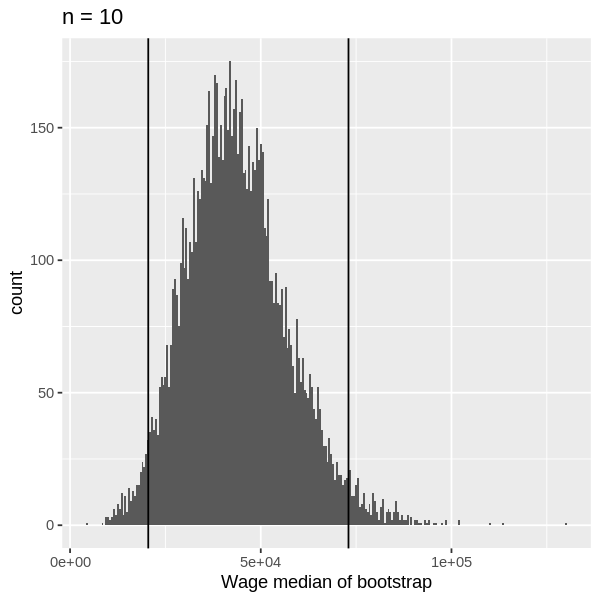

In [76]:
sample_2|>
ggplot(aes(x = bootstrap_med)) +
        geom_histogram(binwidth = 500) +
        xlab("Wage median of bootstrap") +
         geom_vline(xintercept = wage_ci2[[1]]) +
        geom_vline(xintercept = wage_ci2[[2]]) +
        ggtitle("n = 10") 

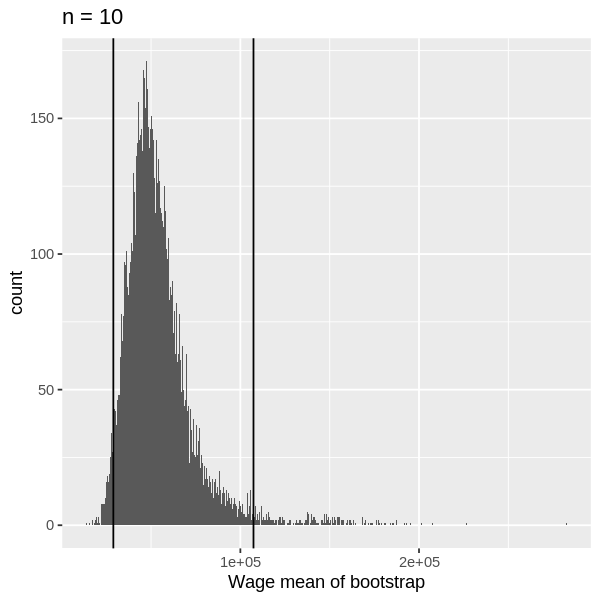

In [77]:
sample_1|>
ggplot(aes(x = bootstrap_mean)) +
        geom_histogram(binwidth = 500) +
        xlab("Wage mean of bootstrap") +
         geom_vline(xintercept = wage_ci1[[1]]) +
        geom_vline(xintercept = wage_ci1[[2]]) +
        ggtitle("n = 10") 

In [79]:
# Perform t-test on wages between males and females
t_test_result <- t.test(wages ~ sex, data = data)

# Print the t-test result
t_test_table <- tidy(t_test_result)
t_test_table


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-21140.17,43954.87,65095.04,-99.2064,0,258062.9,-21557.82,-20722.51,Welch Two Sample t-test,two.sided


estimate: The difference between the average incomes of two groups (male and female) (estimate1 - estimate2).

estimate1: The mean income of females.

estimate2: The mean income of males.

conf.low: The lower limit of the 95% confidence interval for the difference in incomes between the two groups.

conf.high: The upper limit of the 95% confidence interval for the difference in incomes between the two groups.

method: The testing method used, which is Welch's two-sample t-test in this case.

alternative: The type of alternative hypothesis being tested, which is a two-sided test.

## Discussion

## References


Pelletier, R., Patterson, M., & Moyer, M. (2019, October 7). *The gender wage gap in Canada: 1998 to 2018.* Retrieved March 16, 2023, from https://www150.statcan.gc.ca/n1/pub/75-004-m/75-004-m2019004-eng.htm 

*The Gender Wage Gap: It's More Than You Think.* (n.d.). Retrieved March 16, 2023, from https://www.payequity.gov.on.ca/en/LearnMore/GWG/Pages/default.aspx 
